## Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import generate_masterdf as gm
from preproc_funcs import *
from generate_plots import *
from helpers import *
from preproc_funcs import *
from scipy import stats
import plotly.graph_objects as go

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)

msize = 10
axes_fontsize = 14
title_fontsize = 18
%load_ext autoreload
%autoreload 2

Loading existing dataframe! If this is not desired, delete the current mater_df.csv
Loading existing dataframe! If this is not desired, delete the current mater_df.csv


## Summarizing data features

In [2]:
# Loading the data as a dataframe
df_calib_orig = gm.master_calib_df
df_nocalib_orig = gm.master_nocalib_df

# Add additonal error metrics
df_calib_orig = add_metrics(df_calib_orig)
df_nocalib_orig = add_metrics(df_nocalib_orig)

# Preprocess and filter both datasets
df_calib, df_calib_all5 = filter_data(df_calib_orig)
df_nocalib, df_nocalib_all5 = filter_data(df_nocalib_orig)

sub_list_all5 = np.unique(df_calib_all5['subjID'].values)
sub_list = np.unique(df_calib['subjID'].values)

Trials removed = 4686 = 14.25% 
Timing issues = 65 = 0.2% 
No saccades detected issues = 2926 = 8.9% 
Reaction time issues = 178 = 0.54% 
Large errors = 1517 = 4.61% 

Trials removed = 4009 = 12.19% 
Timing issues = 65 = 0.2% 
No saccades detected issues = 2248 = 6.84% 
Reaction time issues = 517 = 1.57% 
Large errors = 1179 = 3.59% 



In [3]:
# Choose what you wanna see
print('Dataframe description')
df_calib.info()
df_calib.describe(include=object)
df_nocalib.info()
df_nocalib.describe(include=object)

Dataframe description
<class 'pandas.core.frame.DataFrame'>
Index: 28194 entries, 0 to 32879
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subjID          28194 non-null  int64  
 1   day             28194 non-null  int64  
 2   gender          28194 non-null  object 
 3   race            28194 non-null  object 
 4   handedness      28194 non-null  object 
 5   hemistimulated  28194 non-null  object 
 6   age             28194 non-null  int64  
 7   weight          28194 non-null  int64  
 8   eegsize         28194 non-null  float64
 9   PT              28194 non-null  float64
 10  StimIntensity   28194 non-null  int64  
 11  rnum            28194 non-null  int64  
 12  tnum            28194 non-null  int64  
 13  istms           28194 non-null  int64  
 14  ispro           28194 non-null  int64  
 15  instimVF        28194 non-null  int64  
 16  TarX            28194 non-null  float64
 17  TarY          

,gender,race,handedness,hemistimulated,trial_type,TMS_condition,TMS_time
count,28871,28871,28871,28871,28871,28871,28871
unique,2,2,2,2,4,3,4
top,M,Asian,Right,Left,pro_outVF,TMS outVF,middle
freq,17432,21720,25858,15329,8980,10736,14546


## Visualization

In [ ]:
# Selecting features
df_to_visualize = df_calib
small_df = df_to_visualize.sample(frac=0.1, random_state=42)

cat_cols = df_calib.select_dtypes(include=['object']).columns
numer_cols = ['age', 'weight', 'TarX', 'TarY', 'isaccX', 'isaccY', 'fsaccX',
       'fsaccY', 'nsacc', 'isacc_rt', 'fsacc_rt', 'isacc_peakvel',
       'fsacc_peakvel', 'ierrX', 'ierrY', 'ferrX',
       'ferrY', 'ierr', 'ferr', 'igain', 'fgain', 'eccentricity', 'polang', 'PT', 'StimIntensity',
       'ipea', 'fpea', 'iang', 'fang', 'itheta', 'iradial', 'itangential',
       'ftheta', 'fradial', 'ftangential', 'ierr_threshold', 'ferr_threshold']

### Visualize numerical columns

In [ ]:
plt.figure(figsize=(25, 40))
for i, col in enumerate(numer_cols):
    plt.subplot(8, 5, i + 1)
    sns.histplot(x=col, data=small_df)
    plt.xticks(rotation=45)
plt.show()

In [ ]:
# Check for correlation in data
plt.figure(figsize=(20, 20))
corr_matrix = df_to_visualize[numer_cols].corr()
mask = (corr_matrix > 0.25) | (corr_matrix < -0.25)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask = ~mask,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.show()

### Visualize categorical columns

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 4, i + 1)
    sns.countplot(x=col, data=df_calib)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
meta_data = df_calib.groupby('subjID').agg({
    'day': 'max',
    'gender': 'first',
    'race': 'first',  
    'handedness': 'first',  
    'hemistimulated': 'first',  
    'age': 'first',
    'weight': 'first',  
    'eegsize': 'first',
    'PT': 'first',
    'StimIntensity': 'first',
    'eccentricity': 'first' 
}).reset_index()
print(meta_data.describe())

        subjID      day      age    weight  eegsize       PT  StimIntensity  \
count  21.0000  21.0000  21.0000   21.0000  21.0000  21.0000        21.0000   
mean   14.4286   4.7143  28.7143   66.3333  57.1429  45.8095        50.9048   
std     7.9219   0.7171   7.3153   13.6247   1.7403   6.1775         6.7743   
min     1.0000   3.0000  21.0000   46.0000  56.0000  35.0000        40.0000   
25%     8.0000   5.0000  25.0000   57.0000  56.0000  42.0000        47.0000   
50%    14.0000   5.0000  27.0000   64.0000  56.0000  45.0000        50.0000   
75%    22.0000   5.0000  30.0000   76.0000  58.0000  50.0000        55.0000   
max    27.0000   5.0000  56.0000  100.0000  60.0000  62.0000        69.0000   

       eccentricity  
count       21.0000  
mean        11.3974  
std          3.8932  
min          3.1615  
25%          7.8474  
50%         12.9801  
75%         13.9532  
max         17.6807  


### Check #trials kept

In [ ]:
daywise_heatmap(df_nocalib, df_nocalib_all5, sub_list, 'trial_count')
daywise_heatmap(df_calib, df_calib_all5, sub_list, 'trial_count')

In [ ]:
daywise_trend(df_calib, df_calib_all5, df_nocalib, df_nocalib_all5, sub_list, 'ierr')

### Subject and block eliminations

In [5]:
subs_to_remove = [8, 11, 13, 16, 18]
#subs_to_remove = []
df_calib_filt, df_calib_all5_filt, df_nocalib_filt, df_nocalib_all5_filt = elim_subs_blocks(df_calib, df_calib_all5, df_nocalib, df_nocalib_all5, subs_to_remove)
sub_list_filt = [ss for ss in sub_list if ss not in subs_to_remove]
sub_list_all5_filt = [ss for ss in sub_list_all5 if ss not in subs_to_remove]

Removed subjects: [8, 11, 13, 16, 18]
Removed blocks df1:
    subjID  day  rnum
0        5    1    10
1        5    3     4
2        5    3     8
3        7    2     2
4       12    2     8
5       12    2     9
6       12    2    10
7       12    3     6
8       12    3     8
9       12    3     9
10      12    3    10
11      15    5     1
12      17    2     4
13      17    2     6
14      17    2     7
15      17    2     8
16      17    3     5
17      22    1     1
18      22    1     7
19      22    4     4
20      22    4     5
21      25    1     8
22      25    1     9
23      25    3     5
24      26    3     5
25      26    3     7
26      26    3    10
27      27    1     1


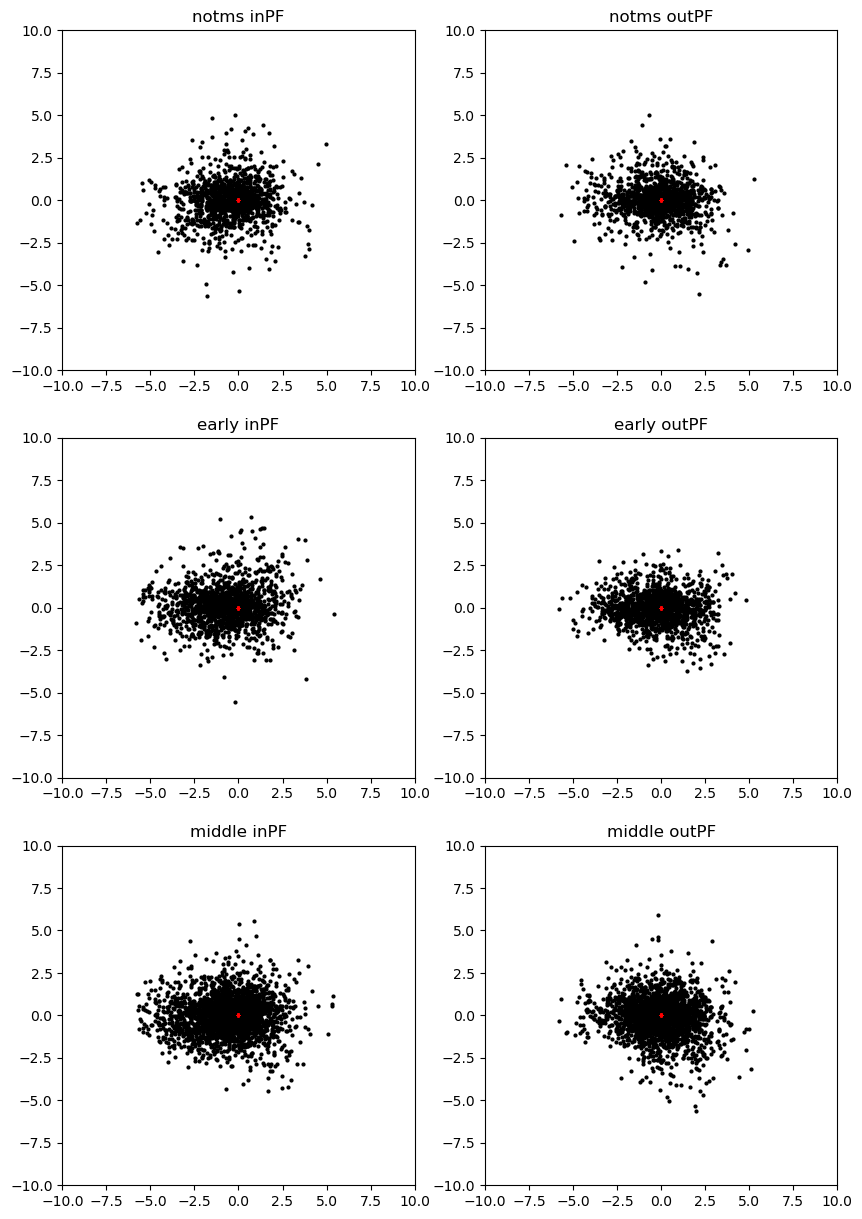

In [6]:
pwidth = 10
tms_conds = ['notms', 'early', 'middle']
f, axs = plt.subplots(3, 2, figsize=(10, 5*3))
for ii in range(len(tms_conds)):
    targXinPF, targYinPF, predXinPF, predYinPF, targXoutPF, targYoutPF, predXoutPF, predYoutPF = combine_rotated_points(tms_conds[ii], sub_list_all5_filt, df_calib_all5_filt, 'initial')
    axs[ii, 0].plot(predXinPF, predYinPF, 'ko', markersize=2)
    axs[ii, 0].plot(targXinPF, targYinPF, 'r*', markersize=2)
    axs[ii, 0].set_xlim([-pwidth, pwidth])
    axs[ii, 0].set_ylim([-pwidth, pwidth])
    axs[ii, 0].set_title(f'{tms_conds[ii]} inPF')

    axs[ii, 1].plot(predXoutPF, predYoutPF, 'ko', markersize=2)
    axs[ii, 1].plot(targXoutPF, targYoutPF, 'r*', markersize=2)
    axs[ii, 1].set_xlim([-pwidth, pwidth])
    axs[ii, 1].set_ylim([-pwidth, pwidth])
    axs[ii, 1].set_title(f'{tms_conds[ii]} outPF')
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/saccdist_initial.eps', format = 'eps', dpi = 1200)
plt.show()

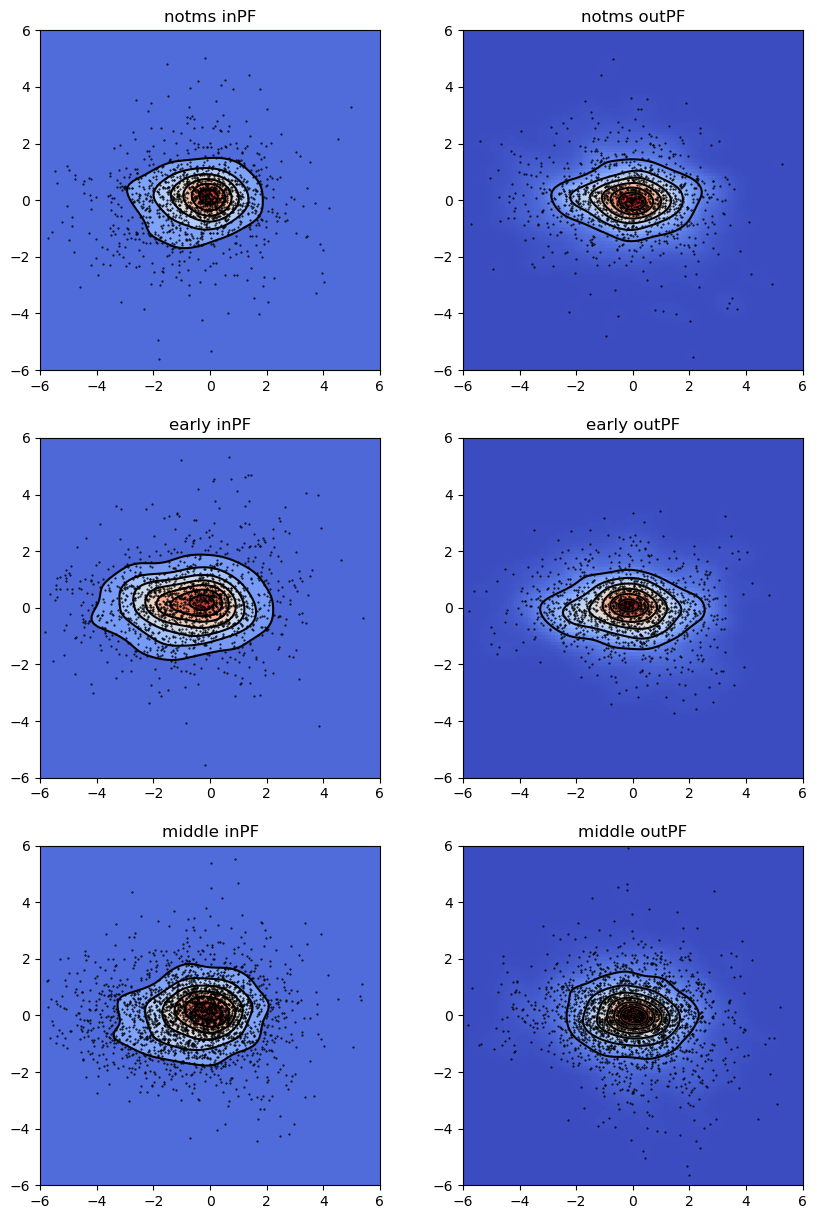

In [35]:
pwidth = 6
xx, yy = np.mgrid[-pwidth:pwidth:100j, -pwidth:pwidth:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

tms_conds = ['notms', 'early', 'middle']
f, axs = plt.subplots(3, 2, figsize=(10, 5*3))
for ii in range(len(tms_conds)):
    targXinPF, targYinPF, predXinPF, predYinPF, targXoutPF, targYoutPF, predXoutPF, predYoutPF = combine_rotated_points(tms_conds[ii], sub_list_all5_filt, df_calib_all5_filt, 'initial')
    axs[ii, 0].plot(predXinPF, predYinPF, 'ko', markersize=0.5)
    # axs[ii, 0].plot(targXinPF, targYinPF, 'r*', markersize=2)
    predIN = np.vstack([predXinPF, predYinPF])
    kernelIN = stats.gaussian_kde(predIN)
    fIN = np.reshape(kernelIN(positions).T, xx.shape)
    cfset = axs[ii, 0].contourf(xx, yy, fIN, cmap = 'coolwarm')
    axs[ii, 0].imshow(np.rot90(fIN), cmap = 'coolwarm', extent=[-pwidth, pwidth, -pwidth, pwidth])
    cset = axs[ii, 0].contour(xx, yy, fIN, colors = 'k')
    axs[ii, 0].set_xlim([-pwidth, pwidth])
    axs[ii, 0].set_ylim([-pwidth, pwidth])
    axs[ii, 0].set_title(f'{tms_conds[ii]} inPF')

    axs[ii, 1].plot(predXoutPF, predYoutPF, 'ko', markersize=0.5)
    # axs[ii, 1].plot(targXoutPF, targYoutPF, 'r*', markersize=2)
    predOUT = np.vstack([predXoutPF, predYoutPF])
    kernelOUT = stats.gaussian_kde(predOUT)
    fOUT = np.reshape(kernelOUT(positions).T, xx.shape)
    cfset = axs[ii, 1].contour(xx, yy, fOUT, cmap = 'coolwarm')
    axs[ii, 1].imshow(np.rot90(fOUT), cmap = 'coolwarm', extent=[-pwidth, pwidth, -pwidth, pwidth])
    cset = axs[ii, 1].contour(xx, yy, fOUT, colors = 'k')
    # sns.kdeplot(x=predXoutPF, y=predYoutPF, ax = axs[ii, 1],  cmap="Purples_r", fill=True)
    axs[ii, 1].set_xlim([-pwidth, pwidth])
    axs[ii, 1].set_ylim([-pwidth, pwidth])
    axs[ii, 1].set_title(f'{tms_conds[ii]} outPF')
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/saccdist_initial.eps', format = 'eps', dpi = 1200)
plt.show()

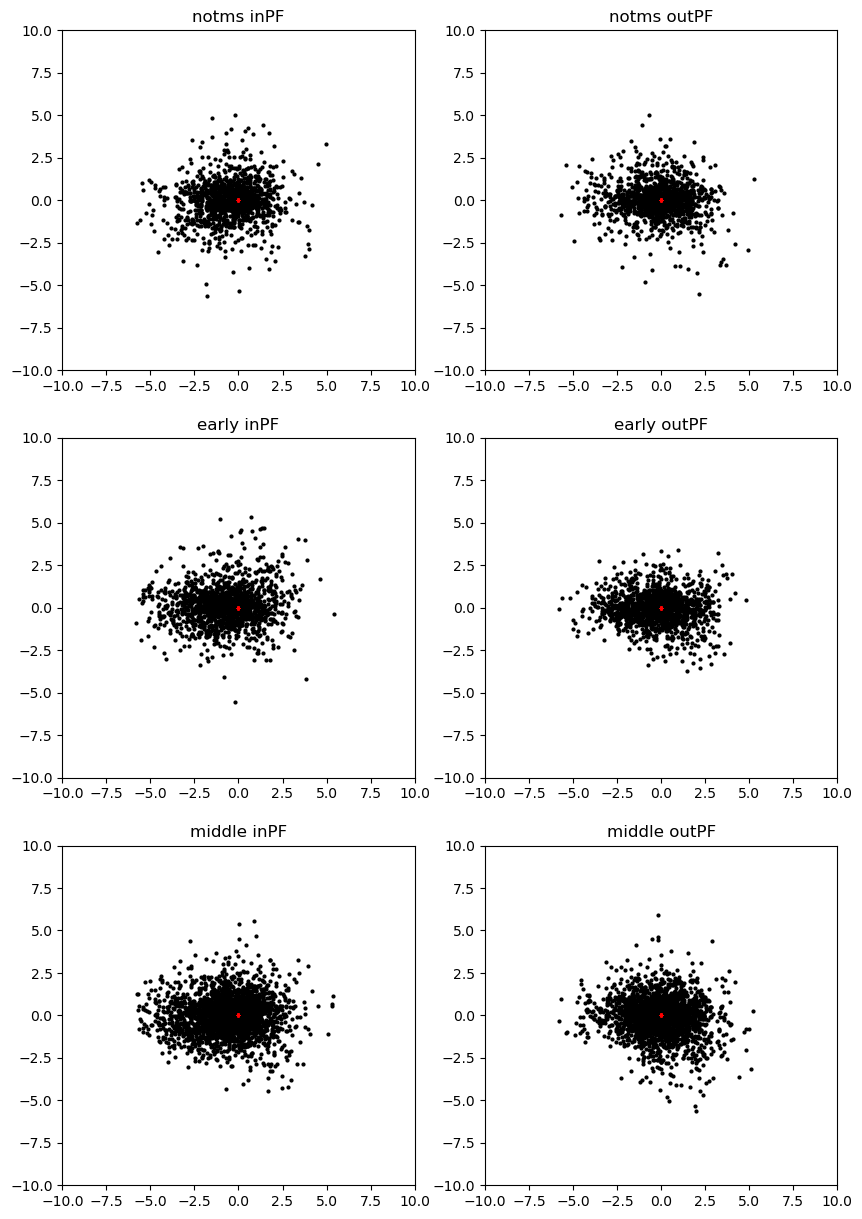

In [36]:
pwidth = 10
tms_conds = ['notms', 'early', 'middle']
f, axs = plt.subplots(3, 2, figsize=(10, 5*3))
for ii in range(len(tms_conds)):
    targXinPF, targYinPF, predXinPF, predYinPF, targXoutPF, targYoutPF, predXoutPF, predYoutPF = combine_rotated_points(tms_conds[ii], sub_list_all5_filt, df_calib_all5_filt, 'initial')
    axs[ii, 0].plot(predXinPF, predYinPF, 'ko', markersize=2)
    axs[ii, 0].plot(targXinPF, targYinPF, 'r*', markersize=2)
    axs[ii, 0].set_xlim([-pwidth, pwidth])
    axs[ii, 0].set_ylim([-pwidth, pwidth])
    axs[ii, 0].set_title(f'{tms_conds[ii]} inPF')

    axs[ii, 1].plot(predXoutPF, predYoutPF, 'ko', markersize=2)
    axs[ii, 1].plot(targXoutPF, targYoutPF, 'r*', markersize=2)
    axs[ii, 1].set_xlim([-pwidth, pwidth])
    axs[ii, 1].set_ylim([-pwidth, pwidth])
    axs[ii, 1].set_title(f'{tms_conds[ii]} outPF')
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/saccdist_initial.eps', format = 'eps', dpi = 1200)
plt.show()

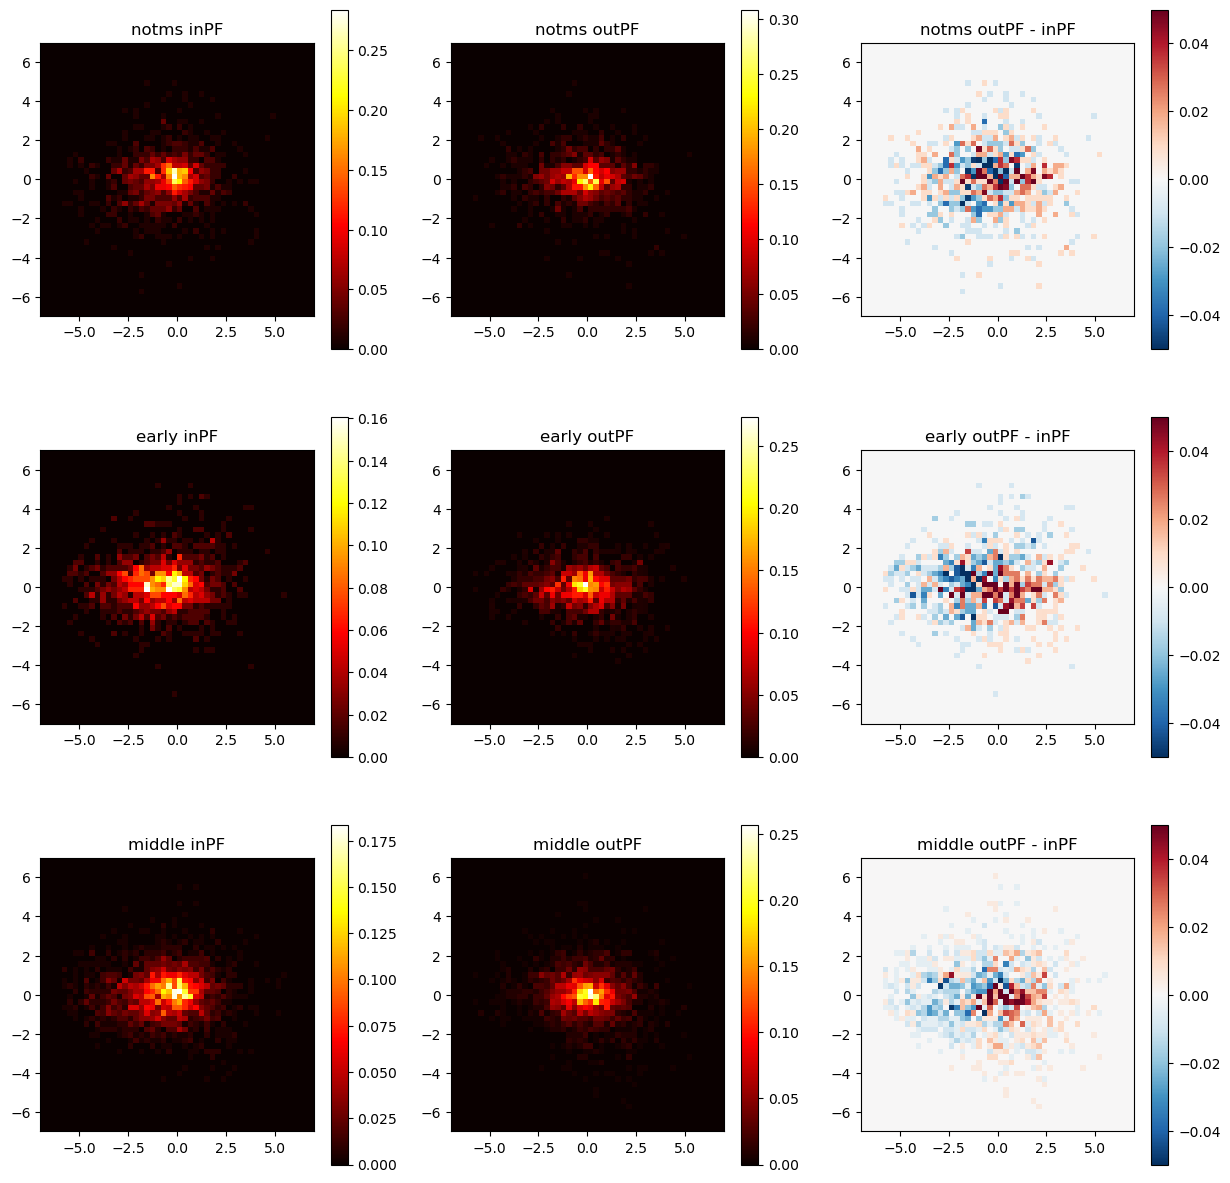

In [37]:
pwidth = 7
tms_conds = ['notms', 'early', 'middle']
f, axs = plt.subplots(3, 3, figsize=(15, 5*3))
for ii in range(len(tms_conds)):
    targXinPF, targYinPF, predXinPF, predYinPF, targXoutPF, targYoutPF, predXoutPF, predYoutPF = combine_rotated_points(tms_conds[ii], sub_list_all5_filt, df_calib_all5_filt, 'initial')
    heatmapin, xedgesin, yedgesin = np.histogram2d(predXinPF, predYinPF, bins=50, density=True, range=[[-pwidth, pwidth], [-pwidth, pwidth]])

    im0 = axs[ii, 0].imshow(heatmapin.T, extent=[xedgesin[0], xedgesin[-1], yedgesin[0], yedgesin[-1]], origin='lower', cmap='hot')
    axs[ii, 0].set_xlim([-pwidth, pwidth])
    axs[ii, 0].set_ylim([-pwidth, pwidth])
    axs[ii, 0].set_title(f'{tms_conds[ii]} inPF')
    f.colorbar(im0, ax=axs[ii, 0], orientation='vertical')

    heatmapout, xedgesout, yedgesout = np.histogram2d(predXoutPF, predYoutPF, bins=50, density=True, range=[[-pwidth, pwidth], [-pwidth, pwidth]])
    im1 = axs[ii, 1].imshow(heatmapout.T, extent=[xedgesout[0], xedgesout[-1], yedgesout[0], yedgesout[-1]], origin='lower', cmap='hot')
    axs[ii, 1].set_xlim([-pwidth, pwidth])
    axs[ii, 1].set_ylim([-pwidth, pwidth])
    axs[ii, 1].set_title(f'{tms_conds[ii]} outPF')
    f.colorbar(im1, ax=axs[ii, 1], orientation='vertical')

    im2 = axs[ii, 2].imshow((heatmapout-heatmapin).T, extent=[xedgesout[0], xedgesout[-1], yedgesout[0], yedgesout[-1]], origin='lower', cmap='RdBu_r', vmin = -0.05, vmax=0.05)
    axs[ii, 2].set_xlim([-pwidth, pwidth])
    axs[ii, 2].set_ylim([-pwidth, pwidth])
    axs[ii, 2].set_title(f'{tms_conds[ii]} outPF - inPF')
    f.colorbar(im2, ax=axs[ii, 2], orientation='vertical')
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/saccdist_initial_heatmap.eps', format = 'eps', dpi = 1200)
plt.show()

In [ ]:
res = 50
std_x = np.linspace(0, 1, res)
std_y = np.linspace(0, 1, res)

actual_error = np.zeros((res, res))
generalized_error = np.zeros((res, res))

for ii in range(res):
    for jj in range(res):
        x = std_x[ii] * np.random.randn(1000)
        y = std_y[jj] * np.random.randn(1000)
        error = (x**2+y**2)
        actual_error[ii, jj] = np.std(error)
        cov_mat = np.cov([x, y])
        generalized_error[ii, jj] = (cov_mat[0,0]*cov_mat[1,1])- (cov_mat[0,1]*cov_mat[1,0])

In [ ]:
plt.figure()
a = plt.imshow(actual_error, cmap ='viridis')
plt.colorbar(a) 

plt.figure()
b = plt.imshow(np.sqrt(generalized_error))
plt.colorbar(b) 
plt.figure()
c = plt.imshow(generalized_error-actual_error)
plt.colorbar(c) 

plt.show()

In [ ]:
tdf = df_calib_filt[['subjID', 'day', 'gender', 'race', 'handedness', 'hemistimulated', 'age', 'weight', 
                          'PT', 'StimIntensity', 'ispro', 'instimVF', 'istms', 'TMS_time', 'ierr', 'isacc_rt']]
tdf[tdf['ispro']==1]
agg_funcs = {
    'gender': 'first',
    'race': 'first',
    'hemistimulated': 'first',
    'handedness': 'first',
    'age': 'first',
    'weight': 'first',
    'PT': 'first',
    'StimIntensity': 'first',
    'ierr': ['mean', 'median', 'var'],
    'isacc_rt': ['mean', 'median', 'var']
}
import socket
import os

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['simnibs_path'] = os.path.join(p['datd'], 'SIMNIBS_output')

# Load up summary data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))

All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}

print_df = tdf.groupby(['subjID', 'TMS_time', 'instimVF']).agg(agg_funcs)
print_df.columns = ['_'.join(col).rstrip('_') for col in print_df.columns.values]
print_df.reset_index(inplace=True)
sinits = []
for ii in range(print_df.shape[0]):
    this_sid = All_metadata[print_df.iloc[ii]['subjID']]['Subject Initials']
    sinits.append(this_sid)
print_df['subjInitial'] = sinits
#print_df.to_csv('/d/DATD/datd/MD_TMS_EEG/analysis/mrugank_tms_summary.csv')

ntdf = print_df[print_df['TMS_time'] == 'notms'].reset_index(drop=True)
early_df = print_df[print_df['TMS_time'] == 'early'].reset_index(drop=True)
middle_df = print_df[print_df['TMS_time'] == 'mid'].reset_index(drop=True)

unique_sublist = ntdf['subjID'].unique()
nt_left_err = []
nt_right_err = []
for ss in unique_sublist:
    this_subidx = ntdf.index[ntdf['subjID']==ss]
    this_subhemi = ntdf.loc[this_subidx[0], 'hemistimulated_first']
    if this_subhemi == 'Left':
        nt_left_err.append(ntdf.loc[this_subidx[0], 'ierr_mean'])
        nt_right_err.append(ntdf.loc[this_subidx[1], 'ierr_mean'])
    else:
        nt_left_err.append(ntdf.loc[this_subidx[1], 'ierr_mean'])
        nt_right_err.append(ntdf.loc[this_subidx[0], 'ierr_mean'])
    # thissub_df = ntdf[ntdf['subjID']==ss].reset_index(drop=True)
    # if thissub_df.loc[0, 'hemistimulated_first'] == 'Left':
    #     nt_left_err = 
df_left = pd.DataFrame()
df_right = pd.DataFrame()
df_left['subjID'] = unique_sublist
df_left['error'] = nt_left_err
df_left['side'] = 0
df_right['subjID'] = unique_sublist
df_right['error'] = nt_right_err
df_right['side'] = 1

df_comb = pd.concat([df_left, df_right])
df_comb.head(20)

plt.figure()
sns.stripplot(data=df_comb, x='side', y='error', color="grey", alpha = 0.6, jitter=False, size=6)
sns.pointplot(data=df_comb, x='side', y='error', linestyle="--", capsize=.1, errorbar="se")
plt.ylim([0, 3])
plt.title('Pro')

In [ ]:
df_calib_filt.to_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_filtered.csv')
df_calib_all5_filt.to_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_all5_filtered.csv')

In [ ]:
data_calib = []
for sub in sub_list_filt:
    tdf_calib = df_calib_filt[df_calib_filt['subjID'] == sub]

    subj_data = {
        ('NoTMS', 'pro', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['rnum'].nunique(),
        ('NoTMS', 'pro', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['tnum'].count(),
        ('NoTMS', 'anti', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['rnum'].nunique(),
        ('NoTMS', 'anti', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['tnum'].count(),
        ('MidTMS', 'pro', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['rnum'].nunique(),
        ('MidTMS', 'pro', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['tnum'].count(),
        ('MidTMS', 'anti', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['rnum'].nunique(),
        ('MidTMS', 'anti', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['tnum'].count(),
        ('EarlyTMS', 'pro', 'block'): tdf_calib[tdf_calib['day'] == 4]['rnum'].nunique(),
        ('EarlyTMS', 'pro', 'trial'): tdf_calib[tdf_calib['day'] == 4]['tnum'].count(),
        ('MidTMS dangit', 'pro', 'block'): tdf_calib[tdf_calib['day'] == 5]['rnum'].nunique(),
        ('MidTMS dangit', 'pro', 'trial'): tdf_calib[tdf_calib['day'] == 5]['tnum'].count(),
    }

    data_calib.append(subj_data)
count_summary_calib = pd.DataFrame(data_calib, index=sub_list_filt)
count_summary_calib.columns = pd.MultiIndex.from_tuples(count_summary_calib.columns)
count_summary_calib.index.name = 'subjID'

data_nocalib = []
for sub in sub_list_filt:
    tdf_nocalib = df_nocalib_filt[df_nocalib_filt['subjID'] == sub]
    subj_data = {
        ('NoTMS', 'pro', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['rnum'].nunique(),
        ('NoTMS', 'pro', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['tnum'].count(),
        ('NoTMS', 'anti', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['rnum'].nunique(),
        ('NoTMS', 'anti', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['tnum'].count(),
        ('MidTMS', 'pro', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['rnum'].nunique(),
        ('MidTMS', 'pro', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['tnum'].count(),
        ('MidTMS', 'anti', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['rnum'].nunique(),
        ('MidTMS', 'anti', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['tnum'].count(),
        ('EarlyTMS', 'pro', 'block'): tdf_nocalib[tdf_nocalib['day'] == 4]['rnum'].nunique(),
        ('EarlyTMS', 'pro', 'trial'): tdf_nocalib[tdf_nocalib['day'] == 4]['tnum'].count(),
        ('MidTMS dangit', 'pro', 'block'): tdf_nocalib[tdf_nocalib['day'] == 5]['rnum'].nunique(),
        ('MidTMS dangit', 'pro', 'trial'): tdf_nocalib[tdf_nocalib['day'] == 5]['tnum'].count(),
    }
    data_nocalib.append(subj_data)
count_summary_nocalib = pd.DataFrame(data_nocalib, index=sub_list_filt)
count_summary_nocalib.columns = pd.MultiIndex.from_tuples(count_summary_nocalib.columns)
count_summary_nocalib.index.name = 'subjID'

def reshape_for_heatmap(df, count_type):
    df_reshaped = df.xs(count_type, level=2, axis=1)
    df_reshaped = df_reshaped.stack([0, 1]).reset_index()
    df_reshaped.columns = ['subjID', 'Condition', 'Type', count_type]
    return df_reshaped

data_calib_block = reshape_for_heatmap(count_summary_calib, 'block')
data_calib_trial = reshape_for_heatmap(count_summary_calib, 'trial')
data_nocalib_block = reshape_for_heatmap(count_summary_nocalib, 'block')
data_nocalib_trial = reshape_for_heatmap(count_summary_nocalib, 'trial')

data_calib = pd.merge(data_calib_block, data_calib_trial, on=['subjID', 'Condition', 'Type'])
data_nocalib = pd.merge(data_nocalib_block, data_nocalib_trial, on=['subjID', 'Condition', 'Type'])

desired_order = [
    ('NoTMS', 'pro'),
    ('NoTMS', 'anti'),
    ('MidTMS', 'pro'),
    ('MidTMS', 'anti'),
    ('EarlyTMS', 'pro'),
    ('MidTMS dangit', 'pro'),
]

p_calib_block = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='block')
p_calib_block = p_calib_block.reindex(desired_order, axis=1)
p_calib_trial = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='trial')
p_calib_trial = p_calib_trial.reindex(desired_order, axis=1)
p_nocalib_block = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='block')
p_nocalib_block = p_nocalib_block.reindex(desired_order, axis=1)
p_nocalib_trial = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='trial')
p_nocalib_trial = p_nocalib_trial.reindex(desired_order, axis=1)

fig, axs = plt.subplots(2, 2, figsize=(15, 25))

sns.heatmap(p_calib_block, cmap='Blues', annot=True, fmt='g', ax=axs[1, 0])
axs[1, 0].set_title('Calib - Block Count')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Subject ID')

sns.heatmap(p_calib_trial, cmap='Greens', annot=True, fmt='g', ax=axs[1, 1])
axs[1, 1].set_title('Calib - Trial Count')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_block, cmap='Blues', annot=True, fmt='g', ax=axs[0, 0])
axs[0, 0].set_title('Nocalib - Block Count')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_trial, cmap='Greens', annot=True, fmt='g', ax=axs[0, 1])
axs[0, 1].set_title('Nocalib - Trial Count')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Subject ID')

plt.show()

In [ ]:
data_calib = []
for sub in sub_list_filt:
    tdf_calib = df_calib_filt[df_calib_filt['subjID'] == sub]

    subj_data = {
        ('NoTMS', 'pro', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['ierr'].mean(),
        ('NoTMS', 'pro', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['isacc_rt'].mean(),
        ('NoTMS', 'anti', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['ierr'].mean(),
        ('NoTMS', 'anti', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['isacc_rt'].mean(),
        ('MidTMS', 'pro', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['ierr'].mean(),
        ('MidTMS', 'pro', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['isacc_rt'].mean(),
        ('MidTMS', 'anti', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['ierr'].mean(),
        ('MidTMS', 'anti', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['isacc_rt'].mean(),
        ('EarlyTMS', 'pro', 'ierr'): tdf_calib[tdf_calib['day'] == 4]['ierr'].mean(),
        ('EarlyTMS', 'pro', 'isacc_rt'): tdf_calib[tdf_calib['day'] == 4]['isacc_rt'].mean(),
        ('MidTMS dangit', 'pro', 'ierr'): tdf_calib[tdf_calib['day'] == 5]['ierr'].mean(),
        ('MidTMS dangit', 'pro', 'isacc_rt'): tdf_calib[tdf_calib['day'] == 5]['isacc_rt'].mean(),
    }

    data_calib.append(subj_data)
count_summary_calib = pd.DataFrame(data_calib, index=sub_list_filt)
count_summary_calib.columns = pd.MultiIndex.from_tuples(count_summary_calib.columns)
count_summary_calib.index.name = 'subjID'


data_nocalib = []
for sub in sub_list_filt:
    tdf_nocalib = df_nocalib_filt[df_nocalib_filt['subjID'] == sub]
    subj_data = {
        ('NoTMS', 'pro', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['ierr'].mean(),
        ('NoTMS', 'pro', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['isacc_rt'].mean(),
        ('NoTMS', 'anti', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['ierr'].mean(),
        ('NoTMS', 'anti', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['isacc_rt'].mean(),
        ('MidTMS', 'pro', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['ierr'].mean(),
        ('MidTMS', 'pro', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['isacc_rt'].mean(),
        ('MidTMS', 'anti', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['ierr'].mean(),
        ('MidTMS', 'anti', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['isacc_rt'].mean(),
        ('EarlyTMS', 'pro', 'ierr'): tdf_nocalib[tdf_nocalib['day'] == 4]['ierr'].mean(),
        ('EarlyTMS', 'pro', 'isacc_rt'): tdf_nocalib[tdf_nocalib['day'] == 4]['isacc_rt'].mean(),
        ('MidTMS dangit', 'pro', 'ierr'): tdf_nocalib[tdf_nocalib['day'] == 5]['ierr'].mean(),
        ('MidTMS dangit', 'pro', 'isacc_rt'): tdf_nocalib[tdf_nocalib['day'] == 5]['isacc_rt'].mean(),
    }
    data_nocalib.append(subj_data)
count_summary_nocalib = pd.DataFrame(data_nocalib, index=sub_list_filt)
count_summary_nocalib.columns = pd.MultiIndex.from_tuples(count_summary_nocalib.columns)
count_summary_nocalib.index.name = 'subjID'

def reshape_for_heatmap(df, count_type):
    df_reshaped = df.xs(count_type, level=2, axis=1)
    df_reshaped = df_reshaped.stack([0, 1]).reset_index()
    df_reshaped.columns = ['subjID', 'Condition', 'Type', count_type]
    return df_reshaped

data_calib_block = reshape_for_heatmap(count_summary_calib, 'ierr')
data_calib_trial = reshape_for_heatmap(count_summary_calib, 'isacc_rt')
data_nocalib_block = reshape_for_heatmap(count_summary_nocalib, 'ierr')
data_nocalib_trial = reshape_for_heatmap(count_summary_nocalib, 'isacc_rt')

data_calib = pd.merge(data_calib_block, data_calib_trial, on=['subjID', 'Condition', 'Type'])
data_nocalib = pd.merge(data_nocalib_block, data_nocalib_trial, on=['subjID', 'Condition', 'Type'])

desired_order = [
    ('NoTMS', 'pro'),
    ('NoTMS', 'anti'),
    ('MidTMS', 'pro'),
    ('MidTMS', 'anti'),
    ('EarlyTMS', 'pro'),
    ('MidTMS dangit', 'pro'),
]

p_calib_block = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='ierr')
p_calib_block = p_calib_block.reindex(desired_order, axis=1)
p_calib_trial = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='isacc_rt')
p_calib_trial = p_calib_trial.reindex(desired_order, axis=1)
p_nocalib_block = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='ierr')
p_nocalib_block = p_nocalib_block.reindex(desired_order, axis=1)
p_nocalib_trial = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='isacc_rt')
p_nocalib_trial = p_nocalib_trial.reindex(desired_order, axis=1)

fig, axs = plt.subplots(2, 2, figsize=(15, 25))

sns.heatmap(p_calib_block, cmap='Blues', annot=True, fmt='.2f', ax=axs[1, 0])
axs[1, 0].set_title('Calib - isacc err')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Subject ID')

sns.heatmap(p_calib_trial, cmap='Greens', annot=True, fmt='.2f', ax=axs[1, 1])
axs[1, 1].set_title('Calib - isacc rt')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_block, cmap='Blues', annot=True, fmt='.2f', ax=axs[0, 0])
axs[0, 0].set_title('Nocalib - fsacc err')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_trial, cmap='Greens', annot=True, fmt='.2f', ax=axs[0, 1])
axs[0, 1].set_title('Nocalib - fsacc rt')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Subject ID')

plt.show()

In [ ]:
daywise_trend(df_calib_filt, df_calib_all5_filt, df_nocalib_filt, df_nocalib_all5_filt, sub_list_filt, 'ierr')

In [ ]:
daywise_trend_dual_metric(df_calib_filt, df_calib_all5_filt, df_nocalib_filt, df_nocalib_all5_filt, sub_list_filt, ['ierr', 'isacc_rt'])

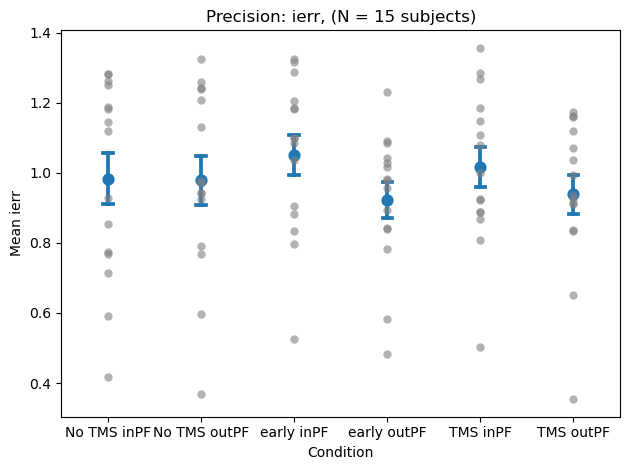

In [48]:
metric = 'ierr'
conds_all5 = {
    # 'No TMS': df_calib_all5_filt[(df_calib_all5_filt['TMS_condition'] == 'No TMS') & (df_calib_all5_filt['day'].isin([1, 2, 3]))],
    'No TMS inPF': df_calib_all5_filt[(df_calib_all5_filt['TMS_condition'] == 'No TMS')  & (df_calib_all5_filt['instimVF'] == 1) & (df_calib_all5_filt['day'].isin([1, 2, 3]))],
    'No TMS outPF': df_calib_all5_filt[(df_calib_all5_filt['TMS_condition'] == 'No TMS')  & (df_calib_all5_filt['instimVF'] == 0) & (df_calib_all5_filt['day'].isin([1, 2, 3]))],
    'early inPF': df_calib_all5_filt[(df_calib_all5_filt['TMS_condition'] == 'TMS intoVF') & (df_calib_all5_filt['day'] == 4)],
    'early outPF': df_calib_all5_filt[(df_calib_all5_filt['TMS_condition'] == 'TMS outVF') & (df_calib_all5_filt['day'] == 4)],
    'TMS inPF': df_calib_all5_filt[(df_calib_all5_filt['TMS_condition'] == 'TMS intoVF') & (df_calib_all5_filt['day'].isin([1, 2, 3]))],
    'TMS outPF': df_calib_all5_filt[(df_calib_all5_filt['TMS_condition'] == 'TMS outVF') & (df_calib_all5_filt['day'].isin([1, 2, 3]))],
}

if metric == 'ierr':
    y_range = [0, 3]
elif metric == 'ferr':
    y_range = [0, 2]
elif metric == 'isacc_rt':
    y_range = [0, 0.6]

results_all5 = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=metric) for cond, data in conds_all5.items()}
combined_all5 = pd.concat(results_all5, names=['Condition']).reset_index()
combined_all5['time'] = combined_all5['Condition'].apply(lambda x: 'notms' if 'No TMS' in x else ('early' if 'early' in x else 'mid'))
combined_all5['PF'] = combined_all5['Condition'].apply(lambda x: 1 if 'inPF' in x else 0)

plt.figure()
sns.stripplot(data=combined_all5, x='Condition', y='se', color="grey", alpha = 0.6, jitter=False, size=6)
sns.pointplot(data=combined_all5, x='Condition', y='se', linestyle="", capsize=.1, errorbar="se")
# plt.title(f'Mean {metric} with Standard Error (N = {len(sub_list_all5_filt)} subjects)')
plt.title(f'Precision: {metric}, (N = {len(sub_list_all5_filt)} subjects)')

plt.ylabel(f'Mean {metric}')
plt.xlabel('Condition')
# plt.ylim(y_range)
plt.tight_layout()
#plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/mean_fradial.eps', format = 'eps', dpi = 1200)
plt.show()

In [ ]:
tdf = combined_all5.copy()
agg_funcs = {
    'mean': ['mean', 'std'],
}
nsubs = len(combined_all5['subjID'].unique())
print_df = tdf.groupby(['Condition', 'PF']).agg(agg_funcs)
#print_df['mean']['std'] = print_df['mean']['std'].values/np.sqrt(nsubs)
print_df.head(20)
#

In [ ]:
aa = print_df['mean']['std'].values/np.sqrt(nsubs)
aa

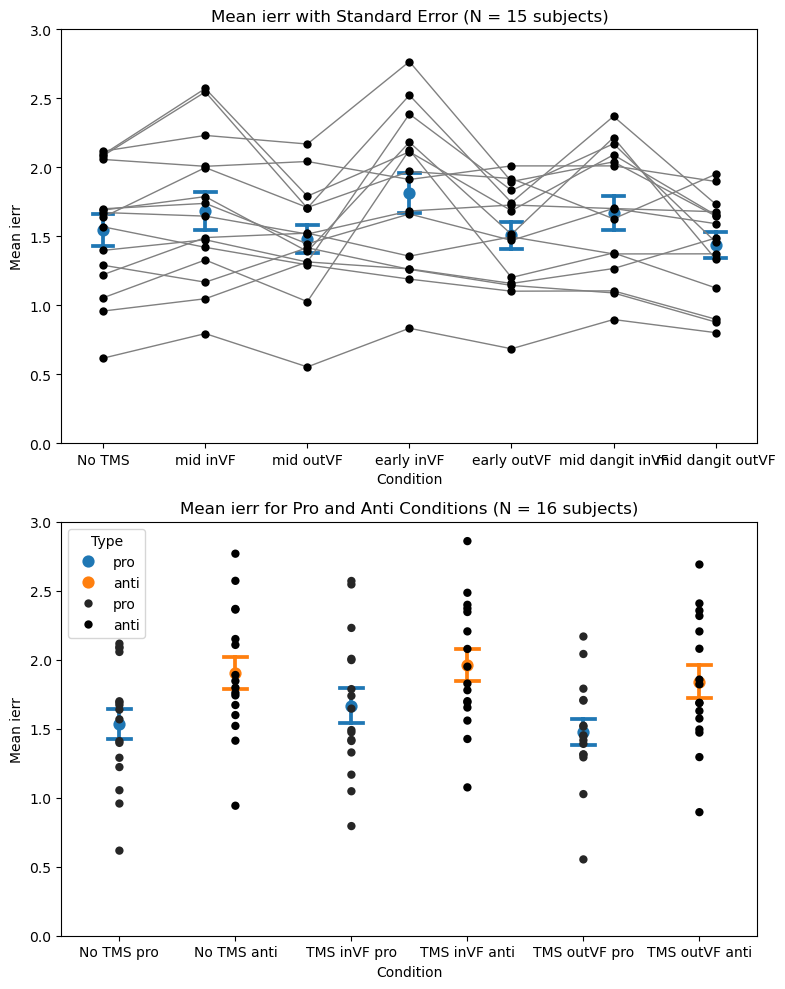

In [7]:
err_sum, err_sum_all5, err_sum_all5_analysis = plot_error_metric(df_calib_filt, df_calib_all5_filt, sub_list_filt, sub_list_all5_filt, 'ierr')

## Statistics

In [ ]:
# Performs non-parametric Friedman followed by post-hoc Wilcoxon
def compute_stats(summary_df, condition, aspect):
    if condition == 'time':
        summary_df = summary_df.groupby(['subjID', 'time']).agg({
            'Condition': 'first',
            'mean': 'mean',
            'se': 'mean'
        })
    
    friedman_data = [group[aspect].values for _, group in summary_df.groupby(condition)]
    friedman_stat, friedman_p = stats.friedmanchisquare(*friedman_data)
    print(f'Statistical analsysis for: {condition}: {aspect}')
    print(f'Friedman Test Statistic: {round(friedman_stat, 3)}, P-value: {round(friedman_p, 3)}')

    if friedman_p < 0.05:
        if condition == 'Condition':
            comparison_pairs = [
                ('mid inVF', 'mid outVF'),
                ('early inVF', 'early outVF'),
                ('mid dangit inVF', 'mid dangit outVF'),
            ]
        elif condition == 'time':
            comparison_pairs = [
                ('notms', 'mid'),
                ('notms', 'early'),
                ('notms', 'mid dangit')
            ]
        num_tests = len(comparison_pairs)+1 # +1 for Friedman test
        alpha_adjusted = 0.05 / num_tests  
        print(f'Corrected alpha value after Bonferroni correction for {num_tests} tests = {round(alpha_adjusted, 4)}')

        results = []

        for pair in comparison_pairs:
            condition1, condition2 = pair
            data1 = summary_df[summary_df[condition] == condition1][aspect]
            data2 = summary_df[summary_df[condition] == condition2][aspect]
            stat, pval = stats.wilcoxon(data1, data2)
            pval_adj = pval * num_tests
            reject = pval < alpha_adjusted
            results.append([condition1, condition2, stat, pval, pval_adj, reject])

        results_df = pd.DataFrame(results, columns=['Condition 1', 'Condition 2', 'WRS_stat', 'p-value', 'adj p-value', 'Reject Null'])
        print(results_df)
          
compute_stats(err_sum_all5, 'Condition', 'mean')
compute_stats(err_sum_all5, 'Condition', 'se')

In [ ]:
# Performs permutation tests by shuffling at the subject level
def compute_diff(x, y, axis):
    return np.mean(x, axis) - np.mean(y, axis)

def perform_permutation_test(df, time1, VF1, time2, VF2, title_text, ax):
    dat1 = df[(df['time'] == time1) & (df['VF'] == VF1)]['mean']
    dat2 = df[(df['time'] == time2) & (df['VF'] == VF2)]['mean']

    res = stats.permutation_test((dat1, dat2), compute_diff, vectorized=True, permutation_type='samples',
                                 n_resamples=1e6, alternative='two-sided', random_state=42)

    sns.histplot(res.null_distribution, element='step', fill=False, ax=ax)
    ax.axvline(x=res.statistic, color='k', linestyle='--')
    # ax.set_xlim([-0.35, 0.35])
    # ax.text(-0.25, 1000.2, f'stat={res.statistic:.3f}\np={res.pvalue:.3f}', fontsize=9, color='black')
    ax.set_title(title_text)
    return res.pvalue

df_analysis = err_sum_all5_analysis

pairs_to_test = [
    ('early', 1, 'early', 0, 'early in vs out'),
    ('mid', 1, 'mid', 0, 'mid in vs out'),
    ('mid dangit', 1, 'mid dangit', 0, 'mid dangit in vs out'),
    ('early', 1, 'notms', 1, 'notms vs early for inVF'),
    ('early', 0, 'notms', 0, 'notms vs early for outVF'),
    ('mid', 1, 'notms', 1, 'notms vs mid for inVF'),
    ('mid', 1, 'mid dangit', 1, 'mid vs mid dangit for inVF')
]

n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i, (time1, VF1, time2, VF2, title_text) in enumerate(pairs_to_test):
    perform_permutation_test(df_analysis, time1, VF1, time2, VF2, title_text, axes[i])
plt.show()

In [ ]:
def get_summary(df_all5, metric):
    conds_all5_analysis = {
        'No TMS inVF': df_all5[(df_all5['istms'] == 0) & (df_all5['instimVF'] == 1) & (df_all5['day'].isin([1, 2, 3]))],
        'No TMS outVF': df_all5[(df_all5['istms'] == 0) & (df_all5['instimVF'] == 0) & (df_all5['day'].isin([1, 2, 3]))],
        'mid inVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 1) & (df_all5['day'].isin([1, 2, 3]))],
        'mid outVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 0) & (df_all5['day'].isin([1, 2, 3]))],
        'early inVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 1) & (df_all5['day'] == 4)],
        'early outVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 0) & (df_all5['day'] == 4)],
        'mid dangit inVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 1) & (df_all5['day'] == 5)],
        'mid dangit outVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 0) & (df_all5['day'] == 5)],
    }
    
    results_all5_analysis = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=metric) for cond, data in conds_all5_analysis.items()}
    combined_all5_analysis = pd.concat(results_all5_analysis, names=['Condition']).reset_index()
    combined_all5_analysis['time'] = combined_all5_analysis['Condition'].apply(lambda x: 'notms' if 'No TMS' in x else ('early' if 'early' in x else ('mid dangit' if 'mid dangit' in x else 'mid')))
    combined_all5_analysis['VF'] = combined_all5_analysis['Condition'].apply(lambda x: 1 if 'inVF' in x else 0)
    return combined_all5_analysis

def compute_stats_parametric(df, pairs_to_test):
    tvect = np.zeros((len(pairs_to_test),))
    for i, (time1, VF1, time2, VF2, _) in enumerate(pairs_to_test):
        data1 = df[(df['time'] == time1) & (df['VF'] == VF1)]['mean']
        data2 = df[(df['time'] == time2) & (df['VF'] == VF2)]['mean']
        tstat, _ = stats.ttest_rel(data1, data2, nan_policy = 'omit', alternative='two-sided')
        tvect[i] = tstat
    return tvect
    

start = time.time()
iter_count = 1000
pairs_to_test = [
    ('early', 1, 'early', 0, 'early in vs out'),
    ('mid', 1, 'mid', 0, 'mid in vs out'),
    ('mid dangit', 1, 'mid dangit', 0, 'mid dangit in vs out'),
    ('early', 1, 'notms', 1, 'notms vs early for inVF'),
    ('early', 0, 'notms', 0, 'notms vs early for outVF'),
    ('mid', 1, 'notms', 1, 'notms vs mid for inVF'),
    ('mid', 1, 'mid dangit', 1, 'mid vs mid dangit for inVF')
]
n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)

tstat_compiled = np.zeros((iter_count, len(pairs_to_test)))
    
for ii in range(iter_count):
    #df_temp = df_calib_all5_filt.copy()
    df_temp = df_calib_all5_filt[df_calib_all5_filt['ispro']==1]
    istms_shuffle = np.random.permutation(df_temp['istms'])
    stimVF_shuffle = np.random.permutation(df_temp['instimVF'])
    day_shuffle = np.random.permutation(df_temp['day'])
    df_temp['istms'] = istms_shuffle
    df_temp['instimVF'] = stimVF_shuffle
    df_temp['day'] = day_shuffle
    df_analysis = get_summary(df_temp, 'ferr')
    tvect_this = compute_stats_parametric(df_analysis, pairs_to_test)
    tstat_compiled[ii, :] = tvect_this

df_analysis_real = get_summary(df_calib_all5_filt, 'ferr')
tstat_real = compute_stats_parametric(df_analysis_real, pairs_to_test)
pval_2side = []
pval_1side = []
for ii in range(n_tests):
    if tstat_real[ii] >= 0:
        samps_bothside = sum(tstat_compiled[:, ii] >= tstat_real[ii]) + sum(tstat_compiled[:, ii] < -tstat_real[ii])
    else:
        samps_bothside = sum(tstat_compiled[:, ii] >= -tstat_real[ii]) + sum(tstat_compiled[:, ii] < tstat_real[ii])
    samps_oneside = sum(tstat_compiled[:, ii] >= tstat_real[ii])
    pval_2side.append(samps_bothside/iter_count)
    pval_1side.append(samps_oneside/iter_count)
print(f"Total time taken for running {iter_count} permutations: {round(time.time()-start, 3)} s")

In [ ]:
pairs_to_test = [
    ('notms inVF', 'early inVF', 'notms vs early inVF'),
    ('notms inVF', 'mid inVF', 'notms vs mid inVF'),
    ('notms outVF', 'early outVF', 'notms vs early outVF'),
    ('notms outVF', 'mid outVF', 'notms vs mid outVF'),
    ('mid inVF', 'mid outVF', 'mid in vs out'),
    ('early inVF', 'early outVF', 'early in vs out'),
    ('mid inVF', 'mid dangit inVF', 'mid vs mid dangit inVF'),
]
n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)
iter_count = 10000

metric = 'ierr'
pro_vs_anti = 'pro'
df_type = 'all5'
tstat_real, tstat_permuted, pval_1side, pval_2side = perform_permutation_test(df_calib_all5_filt, pro_vs_anti,
                                                                              pairs_to_test, metric, iter_count,
                                                                              df_type)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i in range(len(pairs_to_test)):
    plot_permutation_result(tstat_permuted, tstat_real, pval_2side, pval_1side, i, pairs_to_test, axes[i])
plt.show()

In [ ]:
pairs_to_test = [
    ('notms inVF', 'notms outVF', 'notms inVF vs outVF'),
    ('notms inVF', 'TMS inVF', 'notms inVF vs TMS inVF'),
    ('notms outVF', 'TMS outVF', 'notms outVF vs TMS outVF'),
    ('TMS inVF', 'TMS outVF', 'TMS in vs out'),
]
n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)
iter_count = 10000

metric = 'ierr'
pro_vs_anti = 'pro'
df_type = 'first_three'
df_input = df_calib_filt[df_calib_filt['day']<4]
tstat_real, tstat_permuted, pval_1side, pval_2side = perform_permutation_test(df_input, pro_vs_anti,
                                                                              pairs_to_test, metric, iter_count,
                                                                              df_type)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i in range(len(pairs_to_test)):
    plot_permutation_result(tstat_permuted, tstat_real, pval_2side, pval_1side, i, pairs_to_test, axes[i])
plt.suptitle(pro_vs_anti+': '+df_type)
plt.show()

In [ ]:
pairs_to_test = [
    ('notms inVF', 'notms outVF', 'notms inVF vs outVF'),
    ('notms inVF', 'TMS inVF', 'notms inVF vs TMS inVF'),
    ('notms outVF', 'TMS outVF', 'notms outVF vs TMS outVF'),
    ('TMS inVF', 'TMS outVF', 'TMS in vs out'),
]
n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)
iter_count = 10000

metric = 'ierr'
pro_vs_anti = 'anti'
df_type = 'first_three'
df_input = df_calib_filt[df_calib_filt['day']<4]
tstat_real, tstat_permuted, pval_1side, pval_2side = perform_permutation_test(df_input, pro_vs_anti,
                                                                              pairs_to_test, metric, iter_count,
                                                                              df_type)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i in range(len(pairs_to_test)):
    plot_permutation_result(tstat_permuted, tstat_real, pval_2side, pval_1side, i, pairs_to_test, axes[i])
plt.suptitle(pro_vs_anti+': '+df_type)
plt.show()

Total time taken for running 10000 permutations: 225.485 s


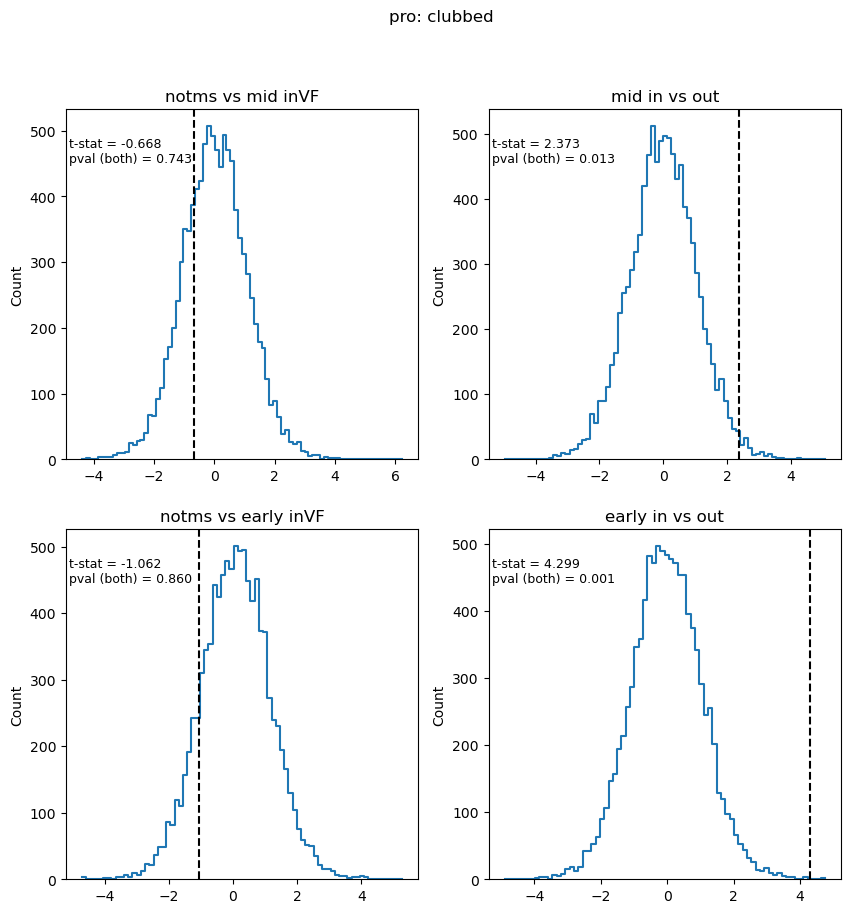

In [47]:
pairs_to_test = [
   # ('notms inVF', 'notms outVF', 'notms inVF vs outVF'),
    ('notms', 'mid inVF', 'notms vs mid inVF'),
    # ('notms', 'mid outVF', 'notms vs mid outVF'),
    ('mid inVF', 'mid outVF', 'mid in vs out'),
    ('notms', 'early inVF', 'notms vs early inVF'),
    # ('notms', 'early outVF', 'notms vs early outVF'),
    ('early inVF', 'early outVF', 'early in vs out'),
]
n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)
iter_count = 10000

metric = 'ierr'
pro_vs_anti = 'pro'
df_type = 'clubbed'
df_input = df_calib_all5_filt#[df_calib_filt['day']<5]
tstat_real, tstat_permuted, pval_1side, pval_2side = perform_permutation_test(df_input, pro_vs_anti,
                                                                              pairs_to_test, metric, iter_count,
                                                                              df_type)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i in range(len(pairs_to_test)):
    plot_permutation_result(tstat_permuted, tstat_real, pval_2side, pval_1side, i, pairs_to_test, axes[i])
plt.suptitle(pro_vs_anti+': '+df_type)
plt.show()

In [ ]:
pairs_to_test = [
   # ('notms inVF', 'notms outVF', 'notms inVF vs outVF'),
    ('notms', 'TMS inVF', 'notms vs TMS inVF'),
    ('notms', 'TMS outVF', 'notms vs TMS outVF'),
    ('TMS inVF', 'TMS outVF', 'TMS in vs out'),
]
n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)
iter_count = 10000

metric = 'ierr'
pro_vs_anti = 'anti'
df_type = 'clubbed'
df_input = df_calib_filt[df_calib_filt['day']<4]
tstat_real, tstat_permuted, pval_1side, pval_2side = perform_permutation_test(df_input, pro_vs_anti,
                                                                              pairs_to_test, metric, iter_count,
                                                                             df_type)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i in range(len(pairs_to_test)):
    plot_permutation_result(tstat_permuted, tstat_real, pval_2side, pval_1side, i, pairs_to_test, axes[i])
plt.suptitle(pro_vs_anti+': '+df_type)
plt.show()

### Does intensity of TMS or phosphene threshold predict the effect

In [ ]:
d_temp = df_calib_all5_filt[['subjID', 'day', 'ierr', 'istms', 'instimVF', 'PT', 'StimIntensity']]
notmsinVF = d_temp[(d_temp['instimVF']==1) & 
                               (d_temp['istms']==0) &
                               (d_temp['day'].isin([1, 2, 3]))].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'StimIntensity': 'first'
                               })
notmsoutVF = d_temp[(d_temp['instimVF']==0) & 
                               (d_temp['istms']==0) &
                               (d_temp['day'].isin([1, 2, 3]))].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'StimIntensity': 'first'
                               })
earlyinVF = d_temp[(d_temp['instimVF']==1) & 
                               (d_temp['istms']==1) &
                               (d_temp['day']==4)].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'StimIntensity': 'first'
                               })
earlyoutVF = d_temp[(d_temp['instimVF']==0) & 
                               (d_temp['istms']==1) &
                               (d_temp['day']==4)].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'StimIntensity': 'first'
                               })
midinVF = d_temp[(d_temp['instimVF']==1) & 
                               (d_temp['istms']==1) &
                               (d_temp['day'].isin([1, 2, 3]))].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'StimIntensity': 'first'
                               })
midoutVF = d_temp[(d_temp['instimVF']==0) & 
                               (d_temp['istms']==1) &
                               (d_temp['day'].isin([1, 2, 3]))].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'StimIntensity': 'first'
                               })

PT_vals = notmsinVF['PT']
SI_vals = notmsinVF['StimIntensity']


plt.figure(figsize=(15, 10))

for i in range(1,6):
    x_vals = PT_vals
    if i == 1:
        y_vals = SI_vals
        title_text = 'SI vs PT'
        y_text = 'Stimulus Intensity'
    elif i == 2:
        y_vals = notmsinVF['ierr'] / notmsoutVF['ierr']
        title_text = 'notms in-out vs PT'
        y_text = 'notms in-out'
    elif i == 3:
        y_vals = midinVF['ierr'] / notmsinVF['ierr']
        title_text = 'mid-notms vs PT'
        y_text = 'mid-notms'
    elif i == 4:
        y_vals = earlyinVF['ierr'] / earlyoutVF['ierr']
        title_text = 'early in-out vs PT'
        y_text = 'early in-out'
    elif i == 5:
        y_vals = midinVF['ierr'] / midoutVF['ierr']
        title_text = 'mid in-out vs PT'
        y_text = 'mid in-out'
    plt.subplot(2, 3, i)
    plt.plot(x_vals, y_vals, 'r*')
    ax = plt.gca()
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    plt.plot([x1, x2], [y1, y2], 'k--')
    # plt.xlim([x1, x2])
    # plt.ylim([y1, y2])
    corr, _ = stats.pearsonr(x_vals, y_vals)
    ax.text(x1 + (x2-x1) * 0.1, y2 - (y2-y1) * 0.15, 
            f'r={corr:.2f}', fontsize=9, color='black')
    plt.title(title_text)
    plt.xlabel('Phosphene Threshold (% MSO)')
    plt.ylabel(y_text)
#plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/trends_with.eps', format = 'eps', dpi = 1200)
plt.show()

In [ ]:
d_temp = df_calib_all5_filt[['subjID', 'day', 'ierr', 'istms', 'instimVF', 'PT', 'eccentricity']]
notmsinVF = d_temp[(d_temp['instimVF']==1) & 
                               (d_temp['istms']==0) &
                               (d_temp['day'].isin([1, 2, 3]))].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'eccentricity': 'mean'
                               })
earlyinVF = d_temp[(d_temp['instimVF']==1) & 
                               (d_temp['istms']==1) &
                               (d_temp['day']==4)].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'eccentricity': 'mean'
                               })
earlyoutVF = d_temp[(d_temp['instimVF']==0) & 
                               (d_temp['istms']==1) &
                               (d_temp['day']==4)].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'eccentricity': 'mean'
                               })
midinVF = d_temp[(d_temp['instimVF']==1) & 
                               (d_temp['istms']==1) &
                               (d_temp['day'].isin([1, 2, 3]))].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'eccentricity': 'mean'
                               })
midoutVF = d_temp[(d_temp['instimVF']==0) & 
                               (d_temp['istms']==1) &
                               (d_temp['day'].isin([1, 2, 3]))].reset_index(drop=True).groupby('subjID').agg({
                                   'ierr': 'mean',
                                   'PT': 'first',
                                   'eccentricity': 'mean'
                               })

PT_vals = notmsinVF['PT']
ecc_vals = notmsinVF['eccentricity']

plt.figure(figsize=(15, 10))

for i in range(1,6):
    x_vals = ecc_vals
    if i == 1:
        y_vals = PT_vals
        title_text = 'PT vs eccentricity'
        y_text = 'Phosphene Threshold'
    elif i == 2:
        y_vals = earlyinVF['ierr'] / notmsinVF['ierr']
        title_text = 'early-notms vs eccentricity'
        y_text = 'early-notms'
    elif i == 3:
        y_vals = midinVF['ierr'] / notmsinVF['ierr']
        title_text = 'mid-notms vs eccentricity'
        y_text = 'mid-notms'
    elif i == 4:
        y_vals = earlyinVF['ierr'] / earlyoutVF['ierr']
        title_text = 'early in-out vs eccentricity'
        y_text = 'early in-out'
    elif i == 5:
        y_vals = midinVF['ierr'] / midoutVF['ierr']
        title_text = 'mid in-out vs eccentricity'
        y_text = 'mid in-out'
    plt.subplot(2, 3, i)
    plt.plot(x_vals, y_vals, 'r*')
    ax = plt.gca()
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    plt.plot([x1, x2], [y1, y2], 'k--')
    corr, _ = stats.pearsonr(x_vals, y_vals)
    ax.text(x1 + (x2-x1) * 0.1, y2 - (y2-y1) * 0.15, 
            f'r={corr:.2f}', fontsize=9, color='black')
    plt.title(title_text)
    plt.xlabel('Eccentricity (dva)')
    plt.ylabel(y_text)
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/trends_with_eccentricity.eps', format = 'eps', dpi = 1200)
plt.show()

### Check for Learning Curve

In [ ]:
fig, axs = plt.subplots(len(sub_list_filt), 5, figsize=(20, 7 * len(sub_list)))

for sub in range(len(sub_list_filt)):
    this_sub = sub_list_filt[sub]
    for day in range(5):
        df_today_pro = df_nocalib_filt[(df_nocalib_filt['subjID'] == this_sub) & (df_nocalib_filt['day'] == day+1) & (df_nocalib_filt['ispro'] == 1)]
        df_today_anti = df_nocalib_filt[(df_nocalib_filt['subjID'] == this_sub) & (df_nocalib_filt['day'] == day+1) & (df_nocalib_filt['ispro'] == 0)]
        this_tr_num_pro = ((df_today_pro['rnum'] - 1) * 40 + df_today_pro['tnum'])
        this_tr_num_anti = ((df_today_anti['rnum'] - 1) * 40 + df_today_anti['tnum'])

        axs[sub, day].plot(this_tr_num_pro, df_today_pro['ierr'], 'ko', markersize=2) 
        axs[sub, day].plot(this_tr_num_anti, df_today_anti['ierr'], 'ro', markersize=2) 

        if day >= 3:  
            df_today = df_nocalib_all5_filt[(df_nocalib_all5_filt['subjID'] == this_sub) & (df_nocalib_all5_filt['day'] == day+1)]
            this_tr_num = ((df_today['rnum'] - 1) * 40 + df_today['tnum'])

            if day == 3:  
                color = 'go' 
            elif day == 4:  
                color = 'bo' 

            axs[sub, day].plot(this_tr_num, df_today['ierr'], color, markersize=2)
        axs[sub, day].set_xlabel('Trial')
        axs[sub, day].set_ylabel('MGS Error (dva)')
        axs[sub, day].set_ylim([0, 6.5])
        axs[sub, day].set_title(f'Sub = {this_sub}, Day = {day + 1}')

plt.show()

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

mov_window = 7 

fig, axs = plt.subplots(len(sub_list_filt), 5, figsize=(20, 7 * len(sub_list_filt)))

for sub in range(len(sub_list_filt)):
    this_sub = sub_list_filt[sub]
    for day in range(5):
        is_istms_zero_day = False
        if day < 3:
            df_today_pro = df_calib_filt[(df_calib_filt['subjID'] == this_sub) & (df_calib_filt['day'] == day+1) & (df_calib_filt['ispro'] == 1)]
            df_today_anti = df_calib_filt[(df_calib_filt['subjID'] == this_sub) & (df_calib_filt['day'] == day+1) & (df_calib_filt['ispro'] == 0)]
            this_tr_num_pro = ((df_today_pro['rnum'] - 1) * 40 + df_today_pro['tnum'])
            this_tr_num_anti = ((df_today_anti['rnum'] - 1) * 40 + df_today_anti['tnum'])

            ma_error_pro = moving_average(df_today_pro['ierr'], mov_window)
            ma_error_anti = moving_average(df_today_anti['ierr'], mov_window)

            adj_tr_num_pro = this_tr_num_pro[:len(ma_error_pro)]
            adj_tr_num_anti = this_tr_num_anti[:len(ma_error_anti)]

            axs[sub, day].plot(adj_tr_num_pro, ma_error_pro, 'k-', label='Pro')  
            axs[sub, day].plot(adj_tr_num_anti, ma_error_anti, 'r-', label='Anti')  

            if df_today_pro['istms'].eq(0).any() or df_today_anti['istms'].eq(0).any():
                is_istms_zero_day = True

            for block_start in np.unique(df_today_pro['rnum']):
                axs[sub, day].axvline(x=((block_start - 1) * 40), color='grey', linestyle='--', alpha=0.5)
            for block_start in np.unique(df_today_anti['rnum']):
                axs[sub, day].axvline(x=((block_start - 1) * 40), color='grey', linestyle='--', alpha=0.5)

        elif day >= 3:
            if this_sub in sub_list_all5:
                df_today = df_calib_filt[(df_calib_filt['subjID'] == this_sub) & (df_calib_filt['day'] == day+1)]
                this_tr_num = ((df_today['rnum'] - 1) * 40 + df_today['tnum'])
                ma_error = moving_average(df_today['ierr'], mov_window)
                adj_tr_num = this_tr_num[:len(ma_error)]

                if day == 3:
                    color = 'g-'
                elif day == 4:
                    color = 'b-'
                
                axs[sub, day].plot(adj_tr_num, ma_error, color, label='TMS')

                for block_start in np.unique(df_today['rnum']):
                    axs[sub, day].axvline(x=((block_start - 1) * 40), color='grey', linestyle='--', alpha=0.5)

        if is_istms_zero_day:
            axs[sub, day].spines['top'].set_color('orange')
            axs[sub, day].spines['right'].set_color('orange')
            axs[sub, day].spines['left'].set_color('orange')
            axs[sub, day].spines['bottom'].set_color('orange')
            axs[sub, day].spines['top'].set_linewidth(2)
            axs[sub, day].spines['right'].set_linewidth(2)
            axs[sub, day].spines['left'].set_linewidth(2)
            axs[sub, day].spines['bottom'].set_linewidth(2)

        axs[sub, day].set_xlabel('Trial')
        axs[sub, day].set_ylabel('MGS Error (dva)')
        axs[sub, day].set_ylim([0, 6.5])
        axs[sub, day].set_title(f'Sub = {this_sub}, Day = {day + 1}')
        axs[sub, day].legend()

plt.show()

### Pairwise plots for conditions

In [ ]:
from statsmodels.stats.power import TTestPower 
from statsmodels.stats.power import TTestIndPower 
df_plot = err_sum_all5_analysis
mean_x = df_plot[(df_plot['time']=='mid') & (df_plot['VF']==1)]['mean'] 
mean_y = df_plot[(df_plot['time']=='notms') & (df_plot['VF']==1)]['mean'] 
cohens_d = (np.mean(mean_x)- np.mean(mean_y)) / np.sqrt((np.std(mean_x) ** 2 + np.std(mean_y, ) ** 2) / 2.0)

# cohens_d = (tdf['mean'] - np.mean(tdf['mean']))/np.std(tdf['mean'])
print(cohens_d)

alpha = 0.05
power = 0.8
  
# perform power analysis to find sample size  
# for given effect 
obj = TTestPower() 
n = obj.solve_power(effect_size=cohens_d, alpha=alpha, power=power,  
                     alternative='larger') 
print(n)

obj = TTestIndPower() 
n = obj.solve_power(effect_size=cohens_d, alpha=alpha, power=power,  
                     ratio=1, alternative='two-sided') 
print(n)

<Figure size 2000x1000 with 0 Axes>

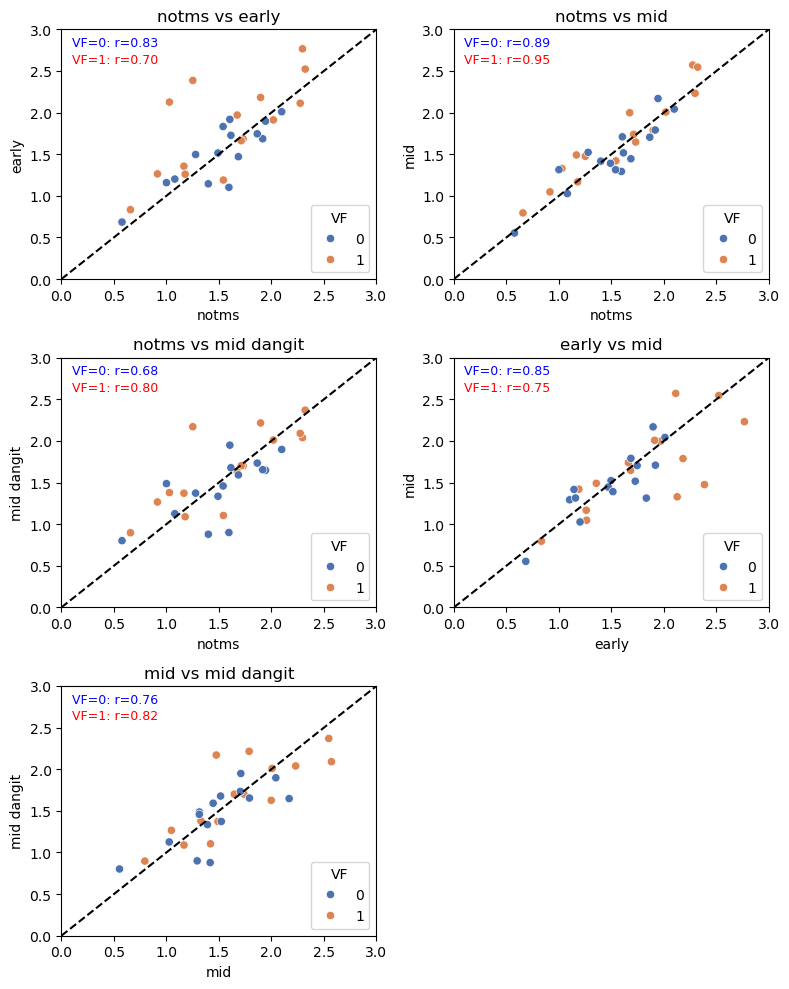

In [8]:
df_plot = err_sum_all5_analysis
plt.figure(figsize=(20, 10))
times = ['notms', 'mid', 'early', 'mid dangit']

time_pairs = [
    ('notms', 'early'),
    ('notms', 'mid'),
    ('notms', 'mid dangit'),
    ('early', 'mid'),
    ('mid', 'mid dangit'),
 ]

# Create figure for the subplots
plt.figure(figsize=(8, 10))

# Plotting each pair of times
for i, (time1, time2) in enumerate(time_pairs, 1):
    plt.subplot(3, 2, i)

    # Merging the mean values for the two times for each subject and condition
    df_time1 = df_plot[df_plot['time'] == time1][['subjID', 'mean', 'VF', 'Condition']]
    df_time2 = df_plot[df_plot['time'] == time2][['subjID', 'mean', 'VF', 'Condition']]
    df_time1.rename(columns={'mean': f'mean_{time1}'}, inplace=True)
    df_time2.rename(columns={'mean': f'mean_{time2}'}, inplace=True)
    merged_df = pd.merge(df_time1, df_time2, on=['subjID', 'VF'])#, 'VF', 'Condition'])

    sns.scatterplot(data=merged_df, x=f'mean_{time1}', y=f'mean_{time2}', hue='VF', palette='deep')
    plt.plot([0, 3], [0, 3], 'k--')
    for vf in [0, 1]:
        vf_data = merged_df[merged_df['VF'] == vf]
        corr, _ = stats.pearsonr(vf_data[f'mean_{time1}'], vf_data[f'mean_{time2}'])
        plt.text(0.1, 2.8 - 0.2 * vf, f'VF={vf}: r={corr:.2f}', fontsize=9, color='blue' if vf == 0 else 'red')

    plt.title(f'{time1} vs {time2}')
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    plt.xlabel(f'{time1}')
    plt.ylabel(f'{time2}')
    plt.legend(title='VF', loc='lower right')

plt.tight_layout()
plt.show()

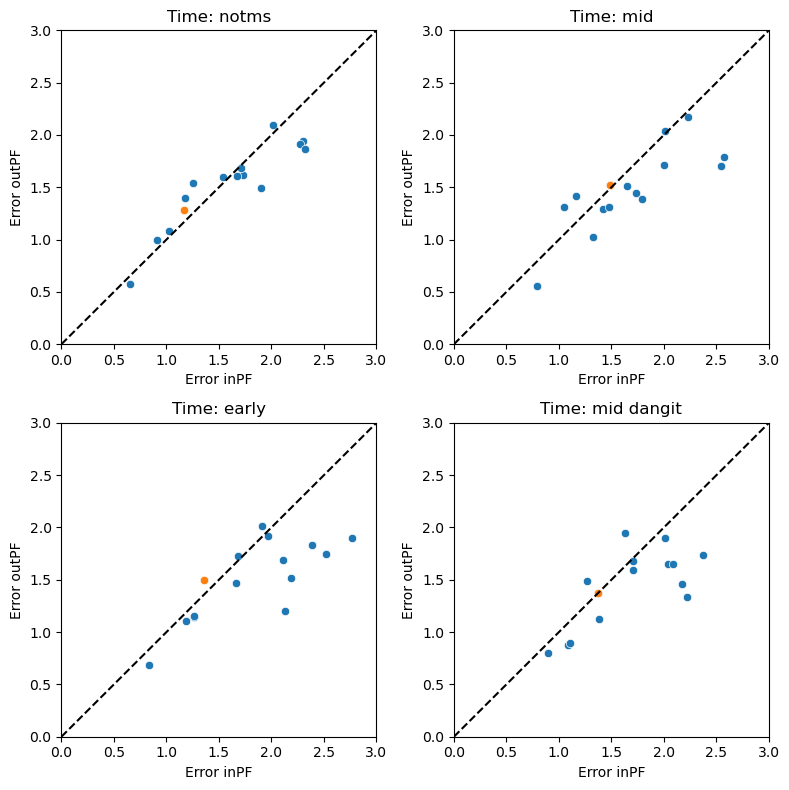

In [12]:
plt.figure(figsize=(8, 8))

for i, time in enumerate(times, 1):
    plt.subplot(2, 2, i)

    df_inVF = df_plot[(df_plot['time'] == time) & (df_plot['VF'] == 1)][['subjID', 'mean']]
    df_outVF = df_plot[(df_plot['time'] == time) & (df_plot['VF'] == 0)][['subjID', 'mean']]
    df_inVF.rename(columns={'mean': 'mean_inVF'}, inplace=True)
    df_outVF.rename(columns={'mean': 'mean_outVF'}, inplace=True)
    merged_df = pd.merge(df_inVF, df_outVF, on='subjID')

    temp_df = merged_df[(merged_df['subjID']==5) | (merged_df['subjID']==24)]

    sns.scatterplot(data=merged_df, x='mean_inVF', y='mean_outVF')
    sns.scatterplot(data = temp_df, x='mean_inVF', y='mean_outVF')
    plt.plot([0, 3], [0, 3], 'k--')
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    corr, _ = stats.pearsonr(merged_df['mean_inVF'], merged_df['mean_outVF'])
    #plt.text(0.1, 2.8, f'r={corr:.2f}', fontsize=9, color='black')
    plt.title(f'Time: {time}')
    plt.xlabel('Error inPF')
    plt.ylabel('Error outPF')

plt.tight_layout()
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/error_in_out_scatter.eps', format = 'eps', dpi = 1200)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

for i, time in enumerate(times, 1):
    plt.subplot(2, 2, i)

    df_inVF = df_plot[(df_plot['time'] == time) & (df_plot['VF'] == 1)][['subjID', 'mean']]
    df_outVF = df_plot[(df_plot['time'] == time) & (df_plot['VF'] == 0)][['subjID', 'mean']]
    df_inVF.rename(columns={'mean': 'mean_inVF'}, inplace=True)
    df_outVF.rename(columns={'mean': 'mean_outVF'}, inplace=True)
    merged_df = pd.merge(df_inVF, df_outVF, on='subjID')

    differences = merged_df['mean_inVF'] - merged_df['mean_outVF']
    kde = stats.gaussian_kde(differences)
    #plt.hist(differences, bins=10, alpha=1, density=True)  # Adjust bins as necessary
    xx = np.linspace(-1, 1, 100)
    plt.plot(xx, kde(xx))
    plt.axvline(x=0, color="black", linestyle="--")
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.xlim([-1, 1])
    plt.title(f'Time: {time}')
plt.tight_layout()
plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/error_in_out_histogram.eps', format = 'eps', dpi = 1200)

plt.show()

## Did subjects use semantic knowledge of target location?

In [ ]:
sub_list = np.unique(df['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 3, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror',
          'actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    for day in range(3):
        df_pro_instimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 1) & (df['instimVF'] == 1)]
        df_pro_outstimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 1) & (df['instimVF'] == 0)]
        df_anti_instimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 0) & (df['instimVF'] == 1)]
        df_anti_outstimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 0) & (df['instimVF'] == 0)]
        
        tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
        tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
        tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
        tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
        
        Xpi_sem = np.median(df_pro_instimVF['TarX'])
        Ypi_sem = np.median(df_pro_instimVF['TarY'])
        Xpo_sem = np.median(df_pro_outstimVF['TarX'])
        Ypo_sem = np.median(df_pro_outstimVF['TarY'])
        Xai_sem = np.median(df_anti_instimVF['TarX'])
        Yai_sem = np.median(df_anti_instimVF['TarY'])
        Xao_sem = np.median(df_anti_outstimVF['TarX'])
        Yao_sem = np.median(df_anti_outstimVF['TarY'])

        errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
        errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
        errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
        errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
        
        tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
        tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
        tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
        tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
        

        errpi = df_pro_instimVF['ierr']
        errpo = df_pro_outstimVF['ierr']
        errai = df_anti_instimVF['ierr']
        errao = df_anti_outstimVF['ierr']
        
        
        pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
        po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
        ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
        ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
        pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
        po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
        ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
        ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
        
        bar1 = axs[sub, day].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
        bar2 = axs[sub, day].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
        bar3 = axs[sub, day].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
        bar4 = axs[sub, day].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
        legend_handles.extend([bar1, bar2, bar3, bar4])
        axs[sub, day].set_ylabel('isacc_err')
        axs[sub, day].set_title('Sub = ' + str(this_sub) + ', Day = ' + str(day))
        axs[sub, day].set_xticks(x)
        axs[sub, day].set_xticklabels(labels, rotation = 45)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
sub_list = np.unique(df['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 1, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror',
          'actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    #for day in range(3):
    df_pro_instimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 1) & (df['instimVF'] == 1)]
    df_pro_outstimVF = df[(df['subjID'] == this_sub)  & (df['ispro'] == 1) & (df['instimVF'] == 0)]
    df_anti_instimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 0) & (df['instimVF'] == 1)]
    df_anti_outstimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 0) & (df['instimVF'] == 0)]
    
    tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
    tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
    tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
    tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
    
    Xpi_sem = np.median(df_pro_instimVF['TarX'])
    Ypi_sem = np.median(df_pro_instimVF['TarY'])
    Xpo_sem = np.median(df_pro_outstimVF['TarX'])
    Ypo_sem = np.median(df_pro_outstimVF['TarY'])
    Xai_sem = np.median(df_anti_instimVF['TarX'])
    Yai_sem = np.median(df_anti_instimVF['TarY'])
    Xao_sem = np.median(df_anti_outstimVF['TarX'])
    Yao_sem = np.median(df_anti_outstimVF['TarY'])

    errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
    errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
    errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
    errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
    
    tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
    tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
    tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
    tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
    

    errpi = df_pro_instimVF['ierr']
    errpo = df_pro_outstimVF['ierr']
    errai = df_anti_instimVF['ierr']
    errao = df_anti_outstimVF['ierr']
    
    
    pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
    po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
    ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
    ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
    pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
    po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
    ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
    ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
    
    bar1 = axs[sub].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
    bar2 = axs[sub].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
    bar3 = axs[sub].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
    bar4 = axs[sub].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
    legend_handles.extend([bar1, bar2, bar3, bar4])
    axs[sub].set_ylabel('isacc_err')
    axs[sub].set_title('Sub = ' + str(this_sub))
    axs[sub].set_xticks(x)
    axs[sub].set_xticklabels(labels)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy_subjectwise.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
X1 = [0.3, 0.8, 1.3]
bWidth = 0.2
X2 = [round(x + 0.1, 1) for x in X1]
X_sum = [sum(value) for value in zip(X1, X2)]
x_tick_pos = [round(x/2, 2) for x in X1]
x_label_names = ['No TMS', 'MGS inVF', 'MGS outVF']
Y1_equal = [1, 1, 1]
Y1_specific = [1, 2, 1]
Y1_global = [1, 2, 2]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor((33/255, 33/255, 33/255))
axes_fontsize = 12
title_fontsize = 16
for ii in range(3):
    ax[ii].set_facecolor((33/255, 33/255, 33/255))
    ax[ii].spines['bottom'].set_color('white')
    ax[ii].spines['top'].set_color('white')
    ax[ii].spines['left'].set_color('white')
    ax[ii].spines['right'].set_color('white')
    ax[ii].xaxis.label.set_color('white')
    ax[ii].yaxis.label.set_color('white')
    ax[ii].tick_params(axis='x', colors='white')
    ax[ii].tick_params(axis='y', colors=(33/255, 33/255, 33/255))
    ax[ii].set_ylim((0, 2.2))
    ax[ii].set_xticks(X1, x_label_names, fontsize=axes_fontsize)
    ax[ii].set_ylabel('MGS error', fontsize=axes_fontsize, labelpad=-20)
    if ii == 0:
        bars = ax[ii].bar(X1, Y1_equal, width = bWidth)
        ax[ii].set_title('No effect', color = 'white', fontsize=title_fontsize)
    elif ii == 1:
        bars = ax[ii].bar(X1, Y1_specific, width = bWidth)
        ax[ii].set_title('Specific', color = 'white', fontsize=title_fontsize)
    elif ii == 2:
        bars = ax[ii].bar(X1, Y1_global, width = bWidth)
        ax[ii].set_title('Global', color = 'white', fontsize=title_fontsize)
    
    bars[0].set_color("#1B9E77")
    bars[1].set_color("#D95F02")
    bars[2].set_color("#7570B3")
plt.show()

In [ ]:
d_good = df[df['subjID'] != 18]
pro_rt = d_good[(d_good['ispro']==1) & (d_good['istms']== 0) & (d_good['instimVF'] == 1)]['isacc_rt']
anti_rt = d_good[(d_good['ispro']==0) & (d_good['istms']== 1) & (d_good['instimVF'] == 1)]['isacc_rt']

max_rt = max(np.max(pro_rt), np.max(anti_rt))
#print(max_rt)
nbins = 50
t_bins = np.linspace(0, max_rt, nbins)
t_res = 1/nbins
p_count = np.zeros((nbins, 1))
a_count = np.zeros((nbins, 1))
for ii in range(nbins):
    p_count[ii] = len(np.where((t_bins[ii]<pro_rt) & (pro_rt<t_bins[ii]+t_res))[0])
    a_count[ii] = len(np.where((t_bins[ii]<anti_rt) & (anti_rt<t_bins[ii]+t_res))[0])
p_count = np.cumsum(p_count)/len(pro_rt) * 100
a_count = np.cumsum(a_count)/len(anti_rt) * 100
print('Pro-saccade equivalence point: ' + str(int(round(t_bins[np.where(p_count < 75)[0][-1]]*1000, 0))) + 's')
print('Anti-saccade equivalence point: ' + str(int(round(t_bins[np.where(a_count < 75)[0][-1]]*1000, 0))) + 's')

plt.figure()
plt.plot(t_bins*1000, p_count, 'b-')
plt.plot(t_bins*1000, a_count, 'r-')
plt.xlabel('RT (ms)')
plt.ylabel('% Cummulative')
plt.title('No TMS')
plt.show()

In [ ]:
## Check for any existing trend in data due to eccentricity or angular width
subjIDs = df['subjID'].unique()
angular_width = np.zeros((len(subjIDs), 2) )
eccs = np.zeros((len(subjIDs),2) )
mean_err = np.zeros((len(subjIDs), 2))
median_err = np.zeros((len(subjIDs), 2))
var_err = np.zeros((len(subjIDs), 2))
range_err = np.zeros((len(subjIDs), 2))
err_met = 'isacc_err'

for ii in range(len(subjIDs)):
    this_subj_df_pro = df[(df['subjID']==subjIDs[ii]) & (df['TMS_condition']=='No TMS') & (df['ispro']==1) ]
    this_subj_df_anti = df[(df['subjID']==subjIDs[ii]) & (df['TMS_condition']=='No TMS') & (df['ispro']==0)]
    mean_err[ii, 0] = np.nanmean(this_subj_df_pro[err_met])
    median_err[ii, 0] = np.nanmedian(this_subj_df_pro[err_met])
    var_err[ii, 0] = np.nanvar(this_subj_df_pro[err_met])
    range_err[ii, 0] = np.nanmax(this_subj_df_pro[err_met]) - np.nanmin(this_subj_df_pro[err_met])
    mean_err[ii, 1] = np.nanmean(this_subj_df_anti[err_met])
    median_err[ii, 1] = np.nanmedian(this_subj_df_anti[err_met])
    var_err[ii, 1] = np.nanvar(this_subj_df_anti[err_met])
    range_err[ii, 1] = np.nanmax(this_subj_df_anti[err_met]) - np.nanmin(this_subj_df_anti[err_met])
    angular_width[ii, 0] = (this_subj_df_pro['TarTheta_rotated'].max() - this_subj_df_pro['TarTheta_rotated'].min()) * (180/np.pi)
    angular_width[ii, 1] = (this_subj_df_anti['TarTheta_rotated'].max() - this_subj_df_anti['TarTheta_rotated'].min()) * (180/np.pi)
    eccs[ii, 0] = this_subj_df_pro['TarRadius'].mean()
    eccs[ii, 1] = this_subj_df_anti['TarRadius'].mean()

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
axs[0, 0].plot(eccs[:, 0], mean_err[:, 0], 'bo')
axs[0, 0].plot(eccs[:, 1], mean_err[:, 1], 'ro')
axs[0, 0].set_xlabel('eccentricity')
axs[0, 0].set_ylabel('mean err')

axs[0, 1].plot(eccs[:, 0], median_err[:, 0], 'bo')
axs[0, 1].plot(eccs[:, 1], median_err[:, 1], 'ro')
axs[0, 1].set_xlabel('eccentricity')
axs[0, 1].set_ylabel('median err')

axs[0, 2].plot(eccs[:, 0], var_err[:, 0], 'bo')
axs[0, 2].plot(eccs[:, 1], var_err[:, 1], 'ro')
axs[0, 2].set_xlabel('eccentricity')
axs[0, 2].set_ylabel('var err')

axs[0, 3].plot(eccs[:, 0], range_err[:, 0], 'bo')
axs[0, 3].plot(eccs[:, 1], range_err[:, 1], 'ro')
axs[0, 3].set_xlabel('eccentricity')
axs[0, 3].set_ylabel('range err')

axs[1, 0].plot(angular_width[:, 0], mean_err[:, 0], 'bo')
axs[1, 0].plot(angular_width[:, 1], mean_err[:, 1], 'ro')
axs[1, 0].set_xlabel('angular_width')
axs[1, 0].set_ylabel('mean err')

axs[1, 1].plot(angular_width[:, 0], median_err[:, 0], 'bo')
axs[1, 1].plot(angular_width[:, 1], median_err[:, 1], 'ro')
axs[1, 1].set_xlabel('angular_width')
axs[1, 1].set_ylabel('median err')

axs[1, 2].plot(angular_width[:, 0], var_err[:, 0], 'bo')
axs[1, 2].plot(angular_width[:, 1], var_err[:, 1], 'ro')
axs[1, 2].set_xlabel('angular_width')
axs[1, 2].set_ylabel('var err')

axs[1, 3].plot(angular_width[:, 0], range_err[:, 0], 'bo')
axs[1, 3].plot(angular_width[:, 1], range_err[:, 1], 'ro')
axs[1, 3].set_xlabel('angular_width')
axs[1, 3].set_ylabel('range err')
plt.show()
